In [319]:
# General imports
import os
if os.getcwd().split('/')[-1] != 'deepARTransit':
    os.chdir('../..')
import sys
import warnings
import numpy as np
import matplotlib.pylab as plt
from pixlc import plotting
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['font.size'] = 15
warnings.simplefilter("ignore")

In [320]:
# Experiment selection widget

import ipywidgets as widgets
experiment_button = widgets.RadioButtons(
    options=[os.path.join('cobweb', 'deeparsys_fulltime'),
             os.path.join('cobweb', 'deepartrans_fulltime'), 
             os.path.join('cobweb', 'rlc/deeparsys_nocov'),
             os.path.join('cobweb', 'rlc/deeparsys_cent'),
             os.path.join('cobweb', 'rlc/deeparsys_pix'),
             os.path.join('cobweb', 'rlc/deeparsys_cent_pix')
],
    #value=experiment_folder,
    # rows=10,
    description='\t\t',
    disabled=False
)

## Select an experiment

In [322]:
experiment_button

RadioButtons(description='\t\t', index=3, options=('cobweb/deeparsys_fulltime', 'cobweb/deepartrans_fulltime',…

In [323]:
# Loading the data
from utils.config import get_config_file, process_config
from deepartransit.data_handling import data_generator

experiment_folder = experiment_button.value
experiment_dir = os.path.join('deepartransit', 'experiments', experiment_folder)
config_file = get_config_file(experiment_dir)
config = process_config(config_file)
print('Data and covariates shapes:')
data = data_generator.DataGenerator(config)
width = int(np.sqrt(data.Z.shape[0]))

traces_array = np.load(os.path.join(config.output_dir, 'pred_array.npy'))
pred_instr = traces_array.mean(axis=(0))
length_pred = pred_instr.shape[1]
plc_trans = data.Z[:, config.pretrans_length:config.pretrans_length+config.trans_length+1]

Data and covariates shapes:
(1, 690, 1) (1, 690, 2)


## NN prediction = interpolation traces 

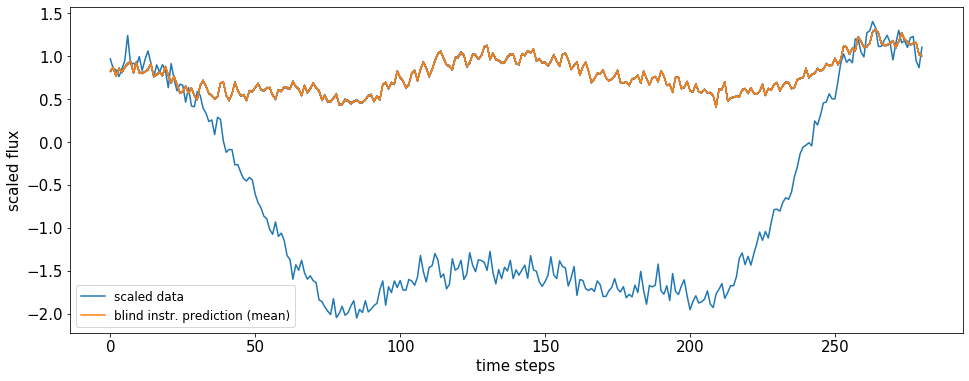

In [324]:
grid = plotting.plot_mozaic(plc_trans.T.reshape(-1, width, width), label='scaled data')
for trace in range(len(traces_array)):
    plotting.plot_mozaic(np.expand_dims(traces_array[trace].T.reshape(-1, width, width), -1), 
                         grid=grid, color='grey', linestyle='dashed', linewidth=1)
plotting.plot_mozaic(pred_instr.T.reshape(-1, width, width), grid=grid, label='blind instr. prediction (mean)')

plt.xlabel('time steps')
plt.ylabel('scaled flux')
plt.legend()

## Back to Original units

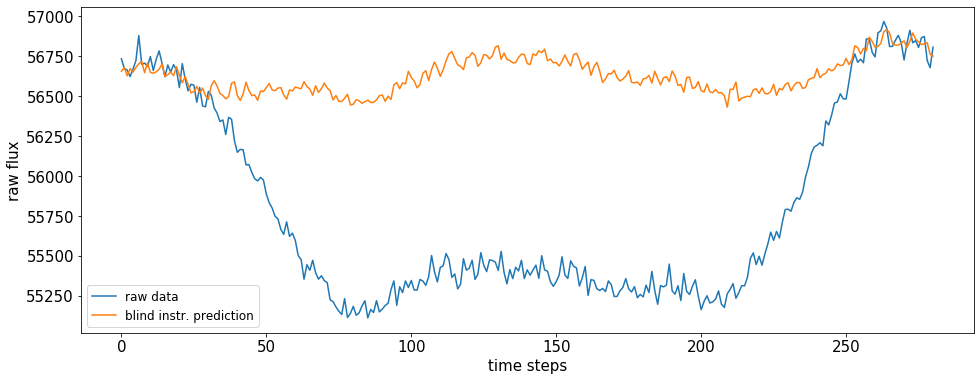

In [325]:
# Back to original scales
plc_trans = data.scaler_Z.inverse_transform(plc_trans)
pred_instr = data.scaler_Z.inverse_transform(pred_instr)
grid = plotting.plot_mozaic(plc_trans.T.reshape(-1, width, width), grid=grid, label='raw data')
plotting.plot_mozaic(pred_instr.T.reshape(-1, width, width), grid=grid, label='blind instr. prediction')
plt.xlabel('time steps')
plt.ylabel('raw flux')
plt.legend()

## Extracting the transit Component

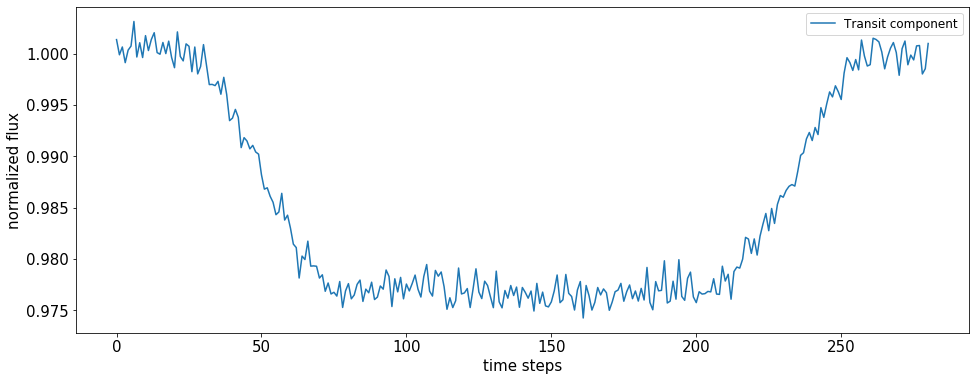

In [326]:
transit_component = (plc_trans/pred_instr)
plotting.plot_mozaic(transit_component.T.reshape(-1, width, width), label='Transit component')
plt.xlabel('time steps')
plt.ylabel('normalized flux')
plt.legend()

## Fitting a linear Transit to the transit component

In [327]:
import scipy.optimize as opt
from utils.transit import transit_linear
time_array = np.linspace(0., 1., length_pred)
(t_c, delta, T, tau), pcov = opt.curve_fit(transit_linear, 
                          np.expand_dims(time_array, 0).repeat(width**2, 0).flatten(), 
                          transit_component[:,:,0].flatten(), 
                          p0=(0.5, 0.1, 0.5, 0.05),
                          bounds= ((0.,0.,0.,0.), (1.,0.5, 1., 0.5)),
                          maxfev=100000)
print('mid_time = {:0.5f}'.format(t_c))
print('delta = {:0.6f} (Rp/Rs = {:0.5f})'.format(delta, np.sqrt(delta)))
print('T = {:0.5f}'.format(T))
print('tau = {:0.5f}'.format(tau))

mid_time = 0.50617
delta = 0.023141 (Rp/Rs = 0.15212)
T = 0.65430
tau = 0.15543


In [328]:
# More transit params
t1 = t_c - T/2 - tau/2  # Beginning of ingress
t2 = t_c - T/2 + tau/2  # End of ingress
t3 = t_c + T/2 - tau/2  # Beginning of egress
t4 = t_c + T/2 + tau/2  # End of egress

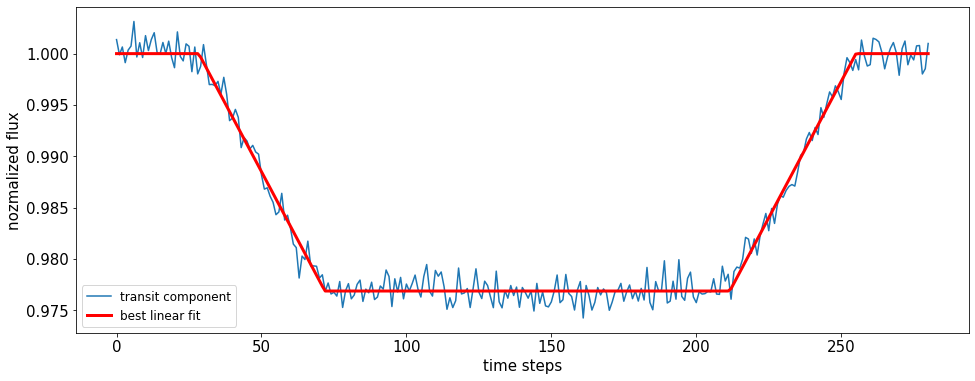

In [329]:
grid = plotting.plot_mozaic(transit_component.T.reshape(-1, width, width), label='transit component')
plotting.plot_mozaic(np.expand_dims(transit_linear(time_array, *popt), -1).repeat(width**2, -1).reshape(-1,width, width), 
                     grid=grid, label='best linear fit', color='red', linewidth=3)
plt.xlabel('time steps')
plt.ylabel('nozmalized flux')
plt.legend()

## Back to the instrument prediction, compared to data/transit

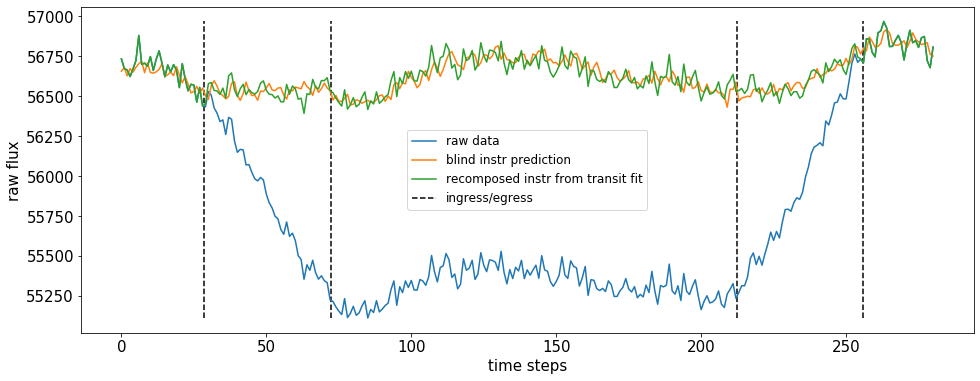

In [332]:
plt.plot(plc_trans.sum(0), label='raw data')
plt.plot(pred_instr.sum(0), label='blind instr prediction')
plt.plot(plc_trans.sum((0, -1))/transit_linear(time_array, *popt), label='recomposed instr from transit fit')
plt.vlines(t1*length_pred, plc_trans.sum(0).min(), plc_trans.sum(0).max(), linestyle='dashed', label = 'ingress/egress')
plt.vlines(t2*length_pred, plc_trans.sum(0).min(), plc_trans.sum(0).max(), linestyle='dashed')
plt.vlines(t3*length_pred, plc_trans.sum(0).min(), plc_trans.sum(0).max(), linestyle='dashed')
plt.vlines(t4*length_pred, plc_trans.sum(0).min(), plc_trans.sum(0).max(), linestyle='dashed')
plt.xlabel('time steps')
plt.ylabel('raw flux')
plt.legend()

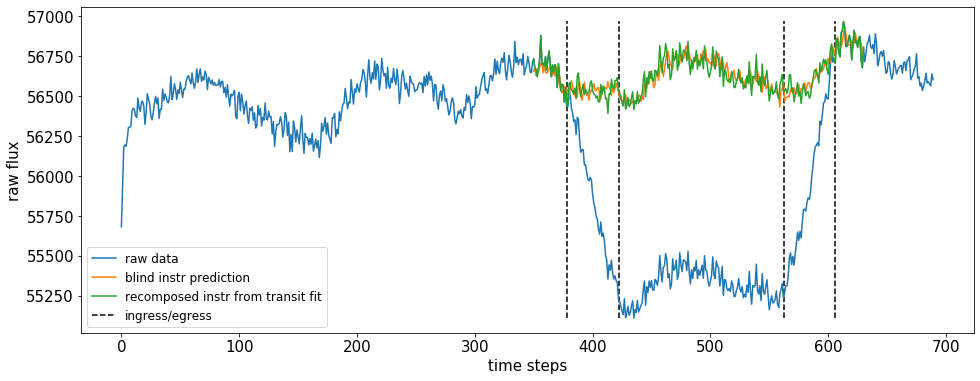

In [333]:
plt.plot(data.scaler_Z.inverse_transform(data.Z)[0,:,0], label='raw data')

plt.plot(range(config.pretrans_length, config.pretrans_length+ config.trans_length + 1), 
         pred_instr.sum(0), label='blind instr prediction')
plt.plot(range(config.pretrans_length, config.pretrans_length+ config.trans_length + 1), 
         plc_trans.sum((0, -1))/transit_linear(time_array, *popt), label='recomposed instr from transit fit')
plt.vlines(t1*length_pred + config.pretrans_length, plc_trans.sum(0).min(), plc_trans.sum(0).max(), linestyle='dashed', label = 'ingress/egress')
plt.vlines(t2*length_pred + config.pretrans_length, plc_trans.sum(0).min(), plc_trans.sum(0).max(), linestyle='dashed')
plt.vlines(t3*length_pred + config.pretrans_length, plc_trans.sum(0).min(), plc_trans.sum(0).max(), linestyle='dashed')
plt.vlines(t4*length_pred + config.pretrans_length, plc_trans.sum(0).min(), plc_trans.sum(0).max(), linestyle='dashed')
plt.xlabel('time steps')
plt.ylabel('raw flux')
plt.legend()
plt.show()
# covariates
# plt.plot(data.scaler_X.inverse_transform(data.X)[0,:,:], label='raw data')
